[View in Colaboratory](https://colab.research.google.com/github/awenare/social_mapper/blob/master/Fraud_Detection_Project_Tina_Kovacova.ipynb)

## Click Fraud Detection - Talking Data

**OVERVIEW: **

The objective is to predict whether a user will download an app after clicking a mobile app advertisement, as well as to discover fraudulent clicks on ads. 

TalkingData, China’s largest independent big data service platform, covers over **70% of active mobile devices nationwide**. They handle **3 billion clicks per day, of which 90% are potentially fraudulent**. Their current approach to prevent click fraud for app developers is to **measure the journey of a user’s click across their portfolio, and flag IP addresses who produce lots of clicks, but never end up installing apps**. With this information, they've built an IP blacklist and device blacklist.

Methodology for Kaggle competition: [Area under the ROC Curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)

<br>

**FINDINGS: **


*   Out of the 100,000 samples in the test file, only 34,857 IP addresses are unique
*   We have categorical variables encoded as integers
*   The list contains 161 apps installed on 100 types of devices using 130 different OS variants
*   Strongest correlation for fraudulent clicks can be found between application, channel and all other variables (OS, device)
*   Logistic Regression already gives us a **0.998 accuracy** on the training and **0.997** on the testing sample.


<br>



**ISSUE TRACKER: **

✅ GitHub limits file upload to 100MB

✅ Git push/pull issues

⚠️ How to import dataset directly from HDD to colab?

⚠️ Upload to Google Drive (see old tutorials) for the 7+ GB full training data file

✅ How to do sorted count of the data by columns?

⚠️ Visualization for the data with no categorical labels (i.e. app name, device type, OS)

⚠️ 



📌 STRETCH: Better Data Cleanup & Feature Engineering

📌 STRETCH: Process this in Spark

### I. Loading the Dataset & Treating Data

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
data_sample = pd.read_csv('https://raw.githubusercontent.com/awenare/Fraud-Detection/master/train_sample.csv', index_col=None)

In [3]:
data_sample.head(5)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


In [4]:
data_sample.shape

(100000, 8)

In [5]:
unique = data_sample.groupby('is_attributed').nunique()
print(unique)

                  ip  app  device   os  channel  click_time  attributed_time  \
is_attributed                                                                  
0              34707  155      91  129      159       80218                0   
1                223   37      25   39       40         227              227   

               is_attributed  
is_attributed                 
0                          1  
1                          1  


#### Data Fields

Each row of the training data contains a click record, with the following features.

**ip:** ip address of click.

**app: ** app id for marketing

**device:** device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)

**os:** os version id of user mobile phone

**channel:** channel id of mobile ad publisher

**click_time:** timestamp of click (UTC)

**attributed_time**: if user download the app for after clicking an ad, this is the time of the app download

**is_attributed:** the target that is to be predicted, indicating the app was downloaded

Note that ip, app, device, os, and channel are encoded.



#### Data Cleanup

In [6]:
# Identifying NaNs

pd.isnull(data_sample).sum()


ip                     0
app                    0
device                 0
os                     0
channel                0
click_time             0
attributed_time    99773
is_attributed          0
dtype: int64

In [7]:
# ⬇️ refactor?

pd.unique(data_sample['ip']).shape

pd.isna('ip')

False

In [8]:
pd.unique(data_sample['app']).shape

pd.isnull('app')

False

In [0]:
pd.unique(data_sample['device']).shape

pd.isna('device')

data_sample.device   #.nunique()

In [10]:
pd.unique(data_sample['os']).shape

pd.isna('os')

data_sample.os.unique()

array([ 13,  17,  19,   1,  25,  22,  20,   2,  90,  10,  18,  40,  15,
        27,  23,  53,  49,  37,  26,  41,   8,  11,   9,  14,  28,  47,
         3,   6,  97,   4,  31,  16,  30,  32,  12,  46, 866,  65,  55,
        29,  42,  39,  34, 607,  79,  35,  44,   7,   0, 748,  36,  99,
        43,  21,  64,  58,  50,  24,  66,  57, 109,  70,  98, 836,  56,
       108,  76, 137,  48,   5,  38,  63, 100,  62,  96,  88,  73,  74,
       138,  45,  84,  52,  61, 172,  59,  81, 102,  77,  78,  60, 153,
        80, 118,  69,  85, 151,  68, 178, 113, 192, 135, 198,  83, 112,
        67, 132,  71, 142, 117, 111, 168, 106, 110, 129, 127, 107, 152,
       155, 199, 133, 116,  92, 196,  87, 174, 207, 184, 114, 185, 193])

In [11]:
pd.unique(data_sample['channel']).shape

pd.isna('channel')

False

In [12]:
# Click time may or may not be potentially useful

pd.unique(data_sample['click_time']).shape

(80350,)

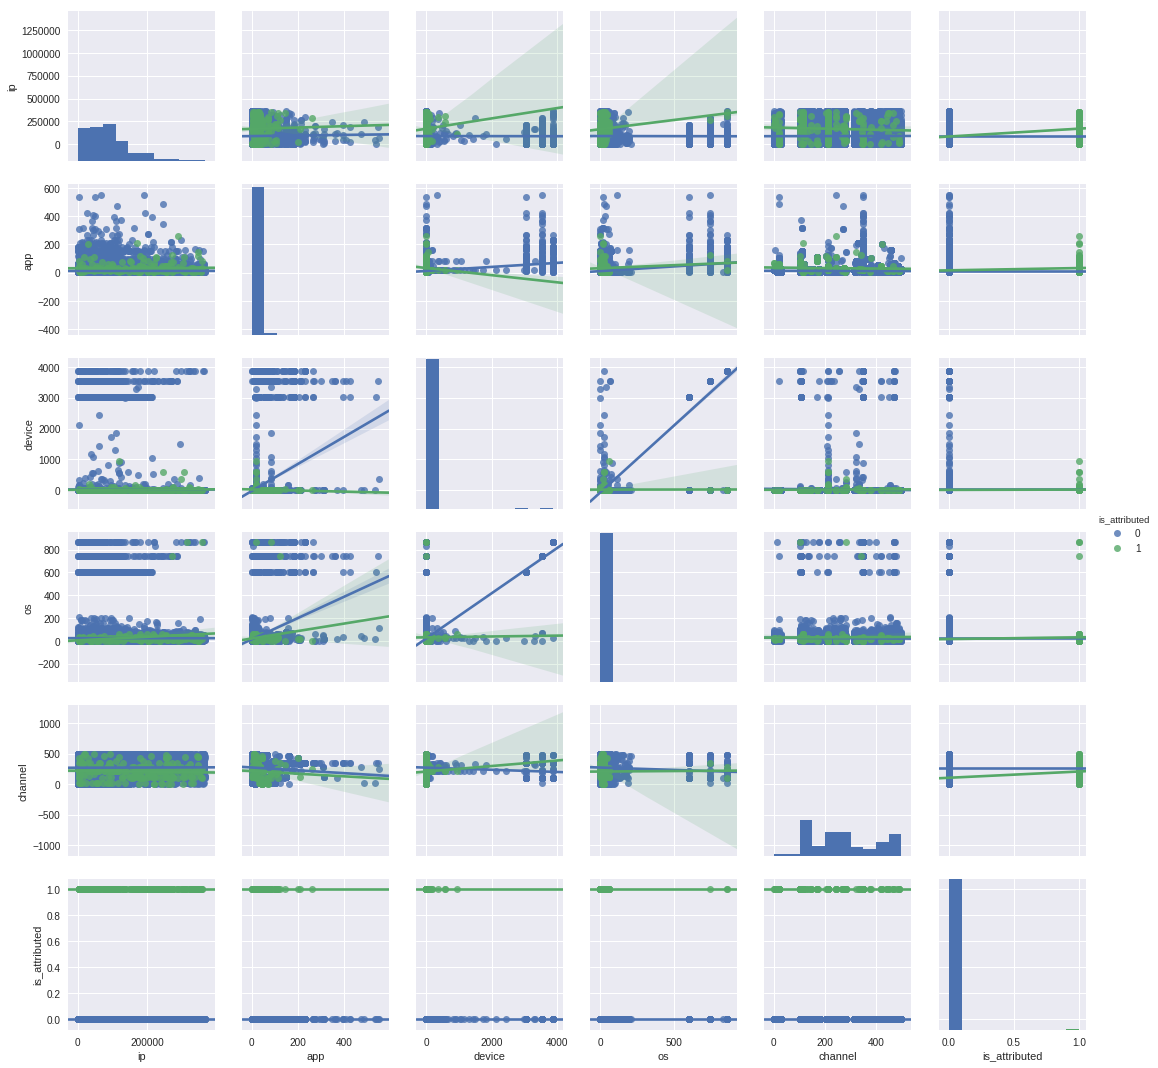

In [13]:
sns.pairplot(data_sample, hue='is_attributed', kind='reg')

In [14]:
print(data_sample['os'].duplicated().sum())

99870


### II. Fitting Initial Baseline Model: Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = data_sample[['app', 'device', 'os', 'channel']].as_matrix() 
# print(X)

Y = data_sample['is_attributed'].values 
# print(Y)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

log_reg = LogisticRegression()
model = log_reg.fit(X_train, y_train)

# Accuracy Scores
print('Accuracy on the training: {:.4f}'.format(model.score(X_train, y_train)))
print('Accuracy on the testing subset: {:.5f}'.format(model.score(X_test, y_test)))

Accuracy on the training: 0.9979
Accuracy on the testing subset: 0.99730


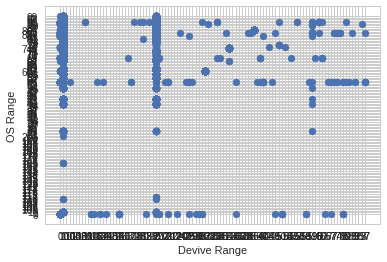

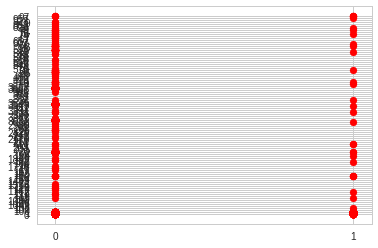

In [41]:
import matplotlib.pyplot as plt

N = 50
x = data_sample[['device']]
y = data_sample[['os']]
# colors = np.random.rand(N)
# area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.scatter(x, y);
plt.xlabel("Devive Range")
plt.ylabel("OS Range")
plt.show()

z = data_sample[['is_attributed']]
plt.scatter(z, x, color='red');
plt.show()

### III. Models Comparison

The main models examined in this case will be

* RKDE: Robust Kernel Density Estimation
* OCSVM: One Class SVM
* LOF: Local Outlier Factor
* IFOR: Isolation Forest

❗️ NEW: [LightGBM](https://lightgbm.readthedocs.io/en/latest/)





#### RKDE: Robust Kernel Density Estimation

#### OCSVM: One Class SVM

#### LOF: Local Outlier Factor

#### IFOR: Isolation Forest

In [17]:
! pip install iso_forest
! pip install jgraph   #igraph is deprecated and renamed to jgraph

    100% |████████████████████████████████| 122kB 5.4MB/s 


In [18]:
import jgraph as ig
import matplotlib.pyplot as plt
import numpy as np
import random as rn
import iso_forest as iso
import copy

/usr/local/lib/python3.6/dist-packages/iso_forest.py:11: UserWarning: No igraph interface for plotting trees
  warnings.warn("No igraph interface for plotting trees")


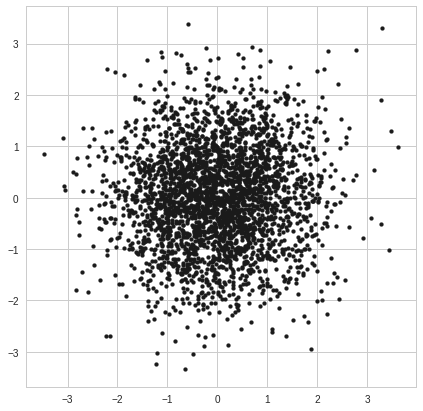

In [19]:
# SAMPLE

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
import random as rn
import iso_forest as iso
import seaborn as sb
sb.set_style(style="whitegrid")
sb.set_color_codes()


mean = [0, 0]
cov = [[1, 0], [0, 1]]  # diagonal covariance
Nobjs = 3000
x, y = np.random.multivariate_normal(mean, cov, Nobjs).T
#Add manual outlier
x[0]=3.3
y[0]=3.3
X=np.array([x,y]).T
plt.figure(figsize=(7,7))
plt.scatter(x,y,s=15,facecolor='k',edgecolor='k')

In [0]:
X = data_sample[['app', 'device', 'os', 'channel']].as_matrix()


F = iso.iForest(X,ntrees=500, sample_size=256)

S=F.compute_paths(X_in=X)

f, axes = plt.subplots(1, 1, figsize=(7, 7), sharex=True)
sb.distplot(S, kde=True, color="b", ax=axes, axlabel='anomaly score')

In [0]:
# USING MY DATA

# from sklearn.ensemble import IsolationForest
import iso_forest as iso

F = iso.iForest(X,ntrees=200, sample_size=256)

S=F.compute_paths(X_in=X)
ss=np.argsort(S)

Automatically created module for IPython interactive environment


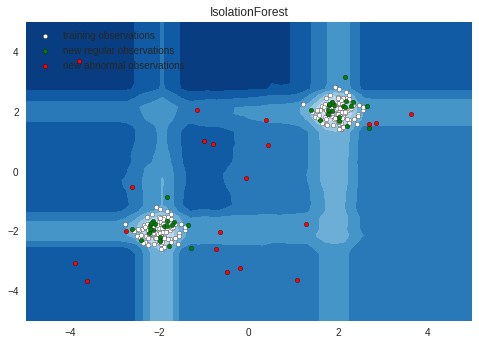

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

rng = np.random.RandomState(42)

# Generate train data
X = 0.3 * rng.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * rng.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = rng.uniform(low=-4, high=4, size=(20, 2))

# fit the model
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

# plot the line, the samples, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("IsolationForest")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white',
                 s=20, edgecolor='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green',
                 s=20, edgecolor='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red',
                s=20, edgecolor='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([b1, b2, c],
           ["training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left")
plt.show()

### IV. Model Application

### V. Complete and Validated Analysis


### VI. Data Visualization